In [297]:
import os
import re
from collections import defaultdict
from itertools import product
import pickle as pkl

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.float_format = '{:,.3f}'.format

network_list = ['resnet18', 'vgg16', 'densenet121']
dataset_list = ['cifar10', 'gtsrb', 'imagenet']
method_list  = ['badnet', 'sig', 'ref', 'warp', 'imc', 'uap', 'ulp']

cmap = {'badnet':'black', 'sig':'yellow', 'ref':'green', 'warp':'orange', 'imc':'red', 'ulp':'blue'}
smap = {'badnet':'o', 'sig':'*', 'ref':'.', 'warp':'x', 'imc':'+', 'ulp':'D'}

logdir = "/scr/songzhu/trojai/uapattack/result"
logs = os.listdir(logdir)

In [309]:
res_dict = defaultdict(list)

for combo in product(method_list, dataset_list, network_list):
    
    method, dataset, network = combo
    logfiles = list(filter(re.compile(f'({method}_{dataset}_{network})+.*').match, logs))
    
    if dataset == 'cifar10':
        asr_thresh:float = 0.90
        acc_thresh:float = 0.80
    elif dataset == 'gtsrb':
        asr_thresh:float = 0.95
        acc_thresh:float = 0.90
    else:
        asr_thresh:float = 0.9
        acc_thresh:float = 0.8
    
    for logfile in logfiles:
        
        with open(os.path.join(logdir, logfile), 'rb') as f:
            config = pkl.load(f)
            result = pkl.load(f)
        f.close()
        
        n_epochs = config['train'][config['args']['dataset']]['N_EPOCHS']
        if n_epochs < 80:
            continue
        
        res_dict['dataset'].append(dataset)
        res_dict['network'].append(network)
        res_dict['method'].append(method)
        
        res_dict['seed'].append(config['args']['seed'])
        res_dict['use_clip'].append(config['train']['USE_CLIP'])
        res_dict['use_transform'].append(config['train']['USE_TRANSFORM'])
        res_dict['use_advtrain'].append(config['adversarial']['ADV_TRAIN'])
        res_dict['use_pretrain'].append(config['network']['PRETRAINED'])
        
        res_dict['acc'].append(max(result['test_clean_acc']))
        res_dict['asr'].append(max(result['test_troj_acc']))
        
        cond = (np.array(result['test_troj_acc']) >= asr_thresh) & (np.array(result['test_clean_acc']) >= acc_thresh)
        
        res_dict['t'].append(np.where(cond==True)[0].min() if sum(cond)>0 else n_epochs)

In [310]:
res_dict = pd.DataFrame(res_dict).drop_duplicates().groupby(by=['dataset', 'network', 'method', 'seed']).first().reset_index()

### No Clip, No DataAug, No AdvTrain, No PreTrain

In [307]:
agg_dict = res_dict.loc[((~res_dict['use_clip']) & (~res_dict['use_transform']) & (~res_dict['use_advtrain']) & (~res_dict['use_pretrain']))]
agg_dict = agg_dict[['dataset', 'network', 'method', 'acc', 'asr', 't']].groupby(by=['dataset', 'network', 'method']).agg(func=['mean', 'std'])
agg_dict['ACC'] = agg_dict['acc']['mean'].round(3).apply(lambda x: '{:,.3f}'.format(x)).astype('str') + r' $\pm$ ' + agg_dict['acc']['std'].round(3).apply(lambda x: '{:,.3f}'.format(x)).astype('str')
agg_dict['ASR'] = agg_dict['asr']['mean'].round(3).apply(lambda x: '{:,.3f}'.format(x)).astype('str') + r' $\pm$ ' + agg_dict['asr']['std'].round(3).apply(lambda x: '{:,.3f}'.format(x)).astype('str')
agg_dict['T'] =agg_dict['t']['mean'].round(3).apply(lambda x: '{:,.3f}'.format(x)).astype('str') + r' $\pm$ ' + agg_dict['t']['std'].round(3).apply(lambda x: '{:,.3f}'.format(x)).astype('str')
agg_dict[['ACC', 'ASR', 'T']].columns = ['ACC', 'ASR', 'T']
agg_dict[['ACC', 'ASR', 'T']]

ACC                ASR  \
                                                                 
dataset  network  method                                         
cifar10  resnet18 badnet  0.843 $\pm$ 0.016  0.999 $\pm$ 0.000   
                  imc     0.880 $\pm$ 0.040  0.999 $\pm$ 0.000   
                  ref     0.849 $\pm$ 0.014  0.999 $\pm$ 0.000   
                  sig     0.866 $\pm$ 0.011  0.999 $\pm$ 0.000   
                  ulp     0.848 $\pm$ 0.017  0.999 $\pm$ 0.000   
                  warp    0.802 $\pm$ 0.007  0.999 $\pm$ 0.001   
         vgg16    badnet  0.889 $\pm$ 0.000  0.999 $\pm$ 0.000   
                  imc     0.882 $\pm$ 0.008  0.999 $\pm$ 0.000   
                  ref     0.886 $\pm$ 0.002  0.999 $\pm$ 0.000   
                  sig     0.888 $\pm$ 0.002  0.999 $\pm$ 0.000   
                  ulp     0.890 $\pm$ 0.004  0.999 $\pm$ 0.000   
                  warp    0.893 $\pm$ 0.009  1.000 $\pm$ 0.000   
gtsrb    resnet18 badnet  0.963 $\pm$ 0.003  0.984 $\pm$ 0.000   
                  imc     0.947 $\pm$ 0.017  0.984 $\pm$ 0.000   
                  ref     0.973 $\pm$ 0.007  0.984 $\pm$ 0.000   
                  sig     0.973 $\pm$ 0.006  0.984 $\pm$ 0.000   
                  ulp     0.967 $\pm$ 0.003  0.984 $\pm$ 0.000   
                  warp    0.938 $\pm$ 0.016  0.457 $\pm$ 0.272   
         vgg16    badnet  0.975 $\pm$ 0.001  0.984 $\pm$ 0.000   
                  imc     0.971 $\pm$ 0.010  0.984 $\pm$ 0.000   
                  ref     0.979 $\pm$ 0.003  0.984 $\pm$ 0.000   
                  sig     0.981 $\pm$ 0.001  0.984 $\pm$ 0.000   
                  ulp     0.980 $\pm$ 0.006  0.984 $\pm$ 0.000   
                  warp    0.971 $\pm$ 0.003  0.996 $\pm$ 0.001   
imagenet resnet18 badnet    0.725 $\pm$ nan    0.980 $\pm$ nan   
                  imc       0.593 $\pm$ nan    0.980 $\pm$ nan   
                  sig       0.721 $\pm$ nan    0.961 $\pm$ nan   
                  ulp       0.727 $\pm$ nan    0.980 $\pm$ nan   
                  warp      0.676 $\pm$ nan    0.993 $\pm$ nan   
         vgg16    badnet    0.800 $\pm$ nan    0.980 $\pm$ nan   
                  sig       0.770 $\pm$ nan    0.882 $\pm$ nan   
                  warp      0.765 $\pm$ nan    0.993 $\pm$ nan   

                                              T  
                                                 
dataset  network  method                         
cifar10  resnet18 badnet     19.000 $\pm$ 1.732  
                  imc        12.000 $\pm$ 4.583  
                  ref        16.000 $\pm$ 2.000  
                  sig        13.000 $\pm$ 3.606  
                  ulp        17.333 $\pm$ 1.155  
                  warp    141.000 $\pm$ 102.191  
         vgg16    badnet      7.333 $\pm$ 3.215  
                  imc         2.667 $\pm$ 1.155  
                  ref         4.667 $\pm$ 0.577  
                  sig         4.667 $\pm$ 2.887  
                  ulp         5.667 $\pm$ 1.528  
                  warp       13.667 $\pm$ 0.577  
gtsrb    resnet18 badnet     12.667 $\pm$ 8.505  
                  imc       16.000 $\pm$ 19.157  
                  ref         2.333 $\pm$ 1.528  
                  sig         2.667 $\pm$ 0.577  
                  ulp         3.000 $\pm$ 0.000  
                  warp      200.000 $\pm$ 0.000  
         vgg16    badnet      1.333 $\pm$ 0.577  
                  imc         1.667 $\pm$ 1.155  
                  ref         0.667 $\pm$ 0.577  
                  sig         1.000 $\pm$ 0.000  
                  ulp         2.000 $\pm$ 0.000  
                  warp       15.000 $\pm$ 2.646  
imagenet resnet18 badnet       80.000 $\pm$ nan  
                  imc          80.000 $\pm$ nan  
                  sig          80.000 $\pm$ nan  
                  ulp          80.000 $\pm$ nan  
                  warp         80.000 $\pm$ nan  
         vgg16    badnet       66.000 $\pm$ nan  
                  sig          80.000 $\pm$ nan  
                  warp       

In [301]:
method_list  = ['badnet', 'sig', 'ref', 'warp', 'imc', 'uap', 'ulp']
dataset = 'cifar10'
network = 'resnet18'

res_dict = defaultdict(list)

for combo in product(method_list, [dataset], [network]):
    
    method, dataset, network = combo
    if method == 'uap':
        continue
        
    logfiles = list(filter(re.compile(f'({method}_{dataset}_{network})+.*').match, logs))
    
    res_dict[method] = defaultdict(list)
    for logfile in logfiles:

        with open(os.path.join(logdir, logfile), 'rb') as f:
            config = pkl.load(f)
            result = pkl.load(f)
        f.close()
        
        n_epochs = config['train'][config['args']['dataset']]['N_EPOCHS']
        if (n_epochs < 80) or \
            (config['train']['USE_CLIP']) or \
            (config['train']['USE_TRANSFORM']) or \
            (config['adversarial']['ADV_TRAIN']) or \
            config['network']['PRETRAINED']:
                continue
        
        res_dict[method][config['args']['seed']] = defaultdict(list)
        
        for asr_thresh in np.linspace(0.9, 1, 50):
            res_dict[method][config['args']['seed']]['asr'].append(asr_thresh)
            cond = (np.array(result['test_troj_acc']) >= asr_thresh) & (np.array(result['test_clean_acc']) >= 0.0)
            res_dict[method][config['args']['seed']]['t_asr'].append(np.where(cond==True)[0].min() if sum(cond)>0 else n_epochs)
            
        for acc_thresh in np.linspace(0.3, 1, 50):
            res_dict[method][config['args']['seed']]['acc'].append(acc_thresh)
            cond = (np.array(result['test_troj_acc']) >= 0.0) & (np.array(result['test_clean_acc']) >= acc_thresh)
            res_dict[method][config['args']['seed']]['t_acc'].append(np.where(cond==True)[0].min() if sum(cond)>0 else n_epochs)

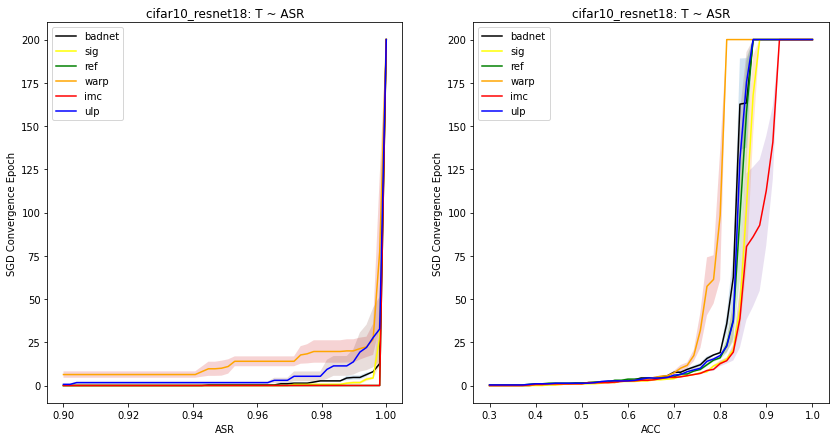

In [302]:
fig = plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
for k in res_dict:
    asr_axis  = list(map(np.mean, zip(*[res_dict[k][seed]['asr'] for seed in res_dict[k]])))
    tasr_axis = list(map(np.mean, zip(*[res_dict[k][seed]['t_asr'] for seed in res_dict[k]])))
    tasr_bar  = list(map(np.std, zip(*[res_dict[k][seed]['t_asr'] for seed in res_dict[k]])))
    
    plt.plot(np.array(asr_axis), np.array(tasr_axis), label=k, linewidth=1.5, color=cmap[k])
    plt.fill_between(np.array(asr_axis), np.array(tasr_axis)-np.array(tasr_bar)/2, np.array(tasr_axis)+np.array(tasr_bar)/2, 
                     alpha=0.2)

plt.xlabel('ASR')
plt.ylabel('SGD Convergence Epoch')
plt.legend()
plt.title(f"{dataset}_{network}: T ~ ASR")

plt.subplot(1, 2, 2)
for k in res_dict:
    acc_axis  = list(map(np.mean, zip(*[res_dict[k][seed]['acc'] for seed in res_dict[k]])))
    tacc_axis = list(map(np.mean, zip(*[res_dict[k][seed]['t_acc'] for seed in res_dict[k]])))
    tacc_bar  = list(map(np.std, zip(*[res_dict[k][seed]['t_acc'] for seed in res_dict[k]])))
    
    plt.plot(np.array(acc_axis), np.array(tacc_axis), label=k, linewidth=1.5, color=cmap[k])
    plt.fill_between(np.array(acc_axis), np.array(tacc_axis)-np.array(tacc_bar)/2, np.array(tacc_axis)+np.array(tacc_bar)/2, 
                     alpha=0.2)

plt.xlabel('ACC')
plt.ylabel('SGD Convergence Epoch')
plt.legend()
plt.title(f"{dataset}_{network}: T ~ ASR")

plt.show()

### With Cliping and DataAug, No AdvTrain, No PreTrain

In [308]:
agg_dict = res_dict.loc[((res_dict['use_clip']) & (res_dict['use_transform']) & (~res_dict['use_advtrain']) & (~res_dict['use_pretrain']))]
agg_dict = agg_dict[['dataset', 'network', 'method', 'acc', 'asr', 't']].groupby(by=['dataset', 'network', 'method']).agg(func=['mean', 'std'])
agg_dict['ACC'] = agg_dict['acc']['mean'].round(3).apply(lambda x: '{:,.3f}'.format(x)).astype('str') + r' $\pm$ ' + agg_dict['acc']['std'].round(3).apply(lambda x: '{:,.3f}'.format(x)).astype('str')
agg_dict['ASR'] = agg_dict['asr']['mean'].round(3).apply(lambda x: '{:,.3f}'.format(x)).astype('str') + r' $\pm$ ' + agg_dict['asr']['std'].round(3).apply(lambda x: '{:,.3f}'.format(x)).astype('str')
agg_dict['T'] =agg_dict['t']['mean'].round(3).apply(lambda x: '{:,.3f}'.format(x)).astype('str') + r' $\pm$ ' + agg_dict['t']['std'].round(3).apply(lambda x: '{:,.3f}'.format(x)).astype('str')
agg_dict[['ACC', 'ASR', 'T']].columns = ['ACC', 'ASR', 'T']
agg_dict[['ACC', 'ASR', 'T']]

,,,ACC,ASR,T
,,,,,
dataset,network,method,,,
